# General Setup

In [2]:
# %debug
# %xmode Plain
# %pdb on

In [3]:
%matplotlib widget

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
import numpy as np
import os

category =  "config1"



In [4]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

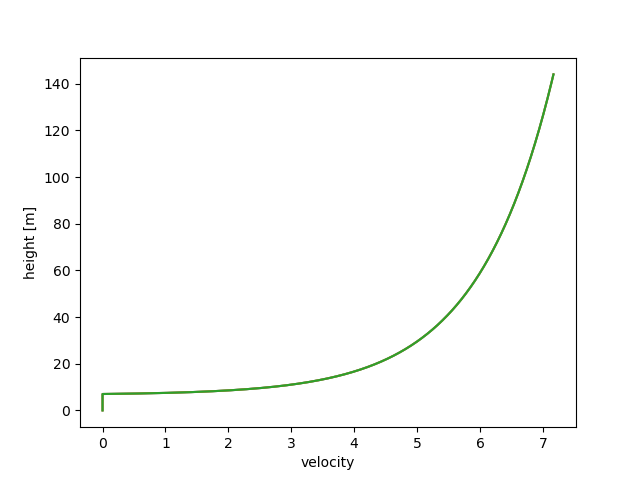

In [5]:
vK_const = .41
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
Lz =  24*hm
z_ref = 10 # really y_ref
U_ref = 4

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)

plt.figure()
LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'Dt': .01,
    'z_values' : np.linspace(0,Lz,10000)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

# physics_setup.plot_log_wind()

plt.plot(ux, LES_params['z_values'])
plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

#

u_bulk is 5.686383242084054
domain height is 144.0
u_bulk is 5.6917076291193105
domain height is 144.0


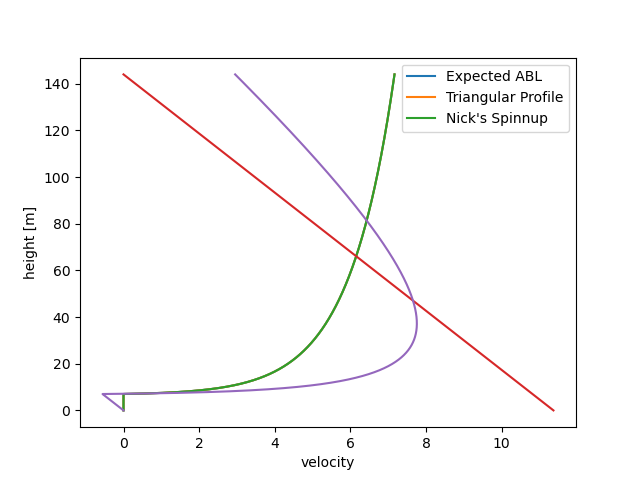

In [6]:
physics_setup.plot_spinup_velocity()

# physics_setup.LES_params['spinup_profile']

# plt.plot(ux, LES_params['z_values'])

# plt.plot(2*ux - np.flip(spinup_profile), LES_params['z_values'])

physics_setup.plot_spinup_velocity2()

plt.legend(('Expected ABL', 'Triangular Profile', "Nick's Spinnup"))

plt.show()


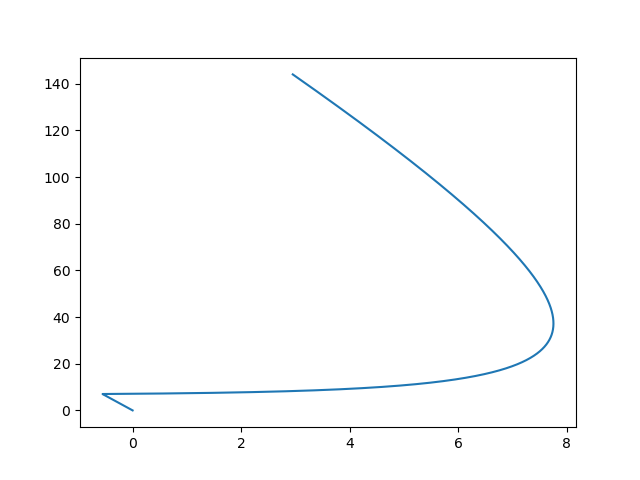

In [7]:
uStar = 0.4958
z0 = 0.366
disp = 6.66
domain_height = 144
vK_const = 0.41

H_scaled = Lz - disp
u_bulk = uStar/vK_const*(H_scaled*np.log(H_scaled/z0) - H_scaled + 1)/Lz

plt.figure()
u_loglaw = (uStar/vK_const)*np.log(y_scaled);
plt.plot(2*(u_loglaw - u_bulk*(np.abs(LES_params['z_values'])/domain_height)), LES_params['z_values'])

In [8]:
display(
    physics_setup.LES_params['uStar'], 
    physics_setup.LES_params['z0'], 
    physics_setup.LES_params['disp'], 
    physics_setup.LES_params['u_bulk']
    )

0.4958117453795493

0.366

6.66

5.6917076291193105

In [9]:
H_scaled = Lz - disp
u_bulk_an = (shear_vel/vK_const*(H_scaled*np.log(H_scaled/z_0) - H_scaled + 1))/Lz

display(u_bulk_an, H_scaled)

5.6917076291193105

137.34

In [10]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )


U infinity is 7.168206228236349 with L = 144.0
flat plate Reynolds number is 70606871.40740058
wall spacing is 0.03251964367353289 for y+ of 500


In [11]:
# NEED TO EXTRACT BETTER NORMALIZING CONSTANT
physics_setup.LES_params['uStar']
physics_setup.LES_params['z_values'][330]
physics_setup.LES_params['log_wind'][330]



0.0

In [12]:
window_dim = hm/2/4

velocity_scaling = 1/physics_setup.LES_params['log_wind'][330]
ventilation_scaling = velocity_scaling/(window_dim**2)
                                        
norm_vel = utils.dict_apply(lambda data_df : data_df*velocity_scaling)
norm_vent = utils.dict_apply(lambda data_df : data_df*velocity_scaling)
abs_values = utils.dict_apply(lambda df : df.abs())

/tmp/ipykernel_11825/3277263610.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  velocity_scaling = 1/physics_setup.LES_params['log_wind'][330]


# Run

In [13]:
run = 3
qois = ['comp(u,0)']

In [14]:
probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/locations')

In [ ]:
# ## 10 m flow statistics
# ref_flow = probes.statistics(
#     names = [name for name in  probes.probe_names if "col" in name], 
#     steps = probes.probe_steps[0:-1:1],
#     quants = ['comp(u,0)','comp(u,2)' ],
#     stack = probes.probe_stack[11],
#     processing = [probePost.time_average],
#     parrallel=True
#     )

In [ ]:
# ref_flow.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/10m_flow')

In [ ]:
norm_data = lambda data_df : data_df*ventilation_scaling

plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : probes.probe_times,
    'stack span' : 'y',
    'xlabel': 'time $[s]$',
    'ylabel' : r'height $[m]$',
    # 'ColorNorm': 'Centered',
    'veritcal scaling' : 1,
    'plot_every': 1000
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = np.s_[::],#probes.probe_steps[100:-10:],
    quants = qois,#,'comp(u,1)','comp(u,2)', 'p'],
    parrallel = True,
    plot_params = plot_params
#     processing = [norm_vel]
    )

plt.show()

In [ ]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

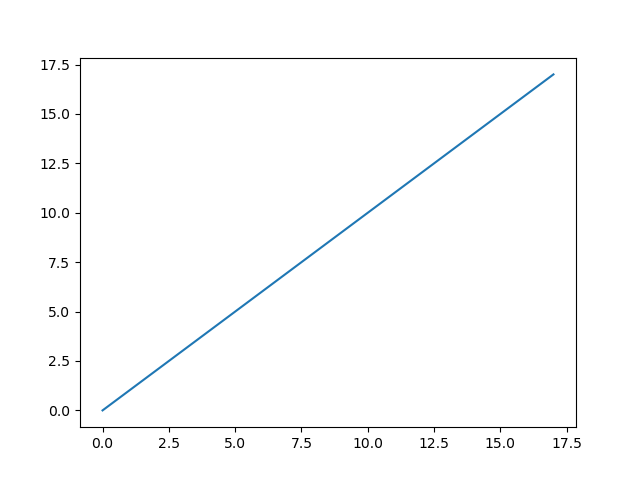

In [17]:
plt.figure()
plt.plot(probes.probe_steps)


In [20]:
probes.profile_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = np.s_[::],#probes.probe_steps[1:5],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'T',
        'ylabel' : r'height $[m]$',
        'veritcal scaling' : 1
        },
    parrallel=True,
    processing = [probePost.time_average]
    )

# plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

IndexError: positional indexers are out-of-bounds

In [ ]:
plt.figure()
raw_data = [1.5292938,1.9054088,2.1489011,1.9980127,1.9612597,2.2905111,2.6067301,2.69891,2.7928826,2.6708404,2.5370963,2.4680873,2.533321,2.421773,2.8411688,2.8411688,3.0117572,3.0006912,2.8828324,3.2942781,3.2942781,3.2629356,3.4876691,3.4876691,3.2638683,3.2638683,3.5769942,3.5769942,3.5769942,3.5342152,3.5342152,3.4892258,3.4892258,3.4892258,3.516562,3.516562,3.6436542,3.6436542,3.6436542,3.6330901,3.571308,3.571308,3.571308,3.571308,3.5937381,3.5937381,3.5937381,3.5937381,3.54775,3.54775,3.54775,3.54775,3.6200349,3.6200349,3.6200349,3.6200349,3.6299999,3.6299999,3.6299999,3.6299999,3.7233506,3.7233506,3.7233506,3.7233506,3.7333596,3.7333596,3.7333596,3.7333596,3.7722806,3.7722806,3.7722806,3.7722806,3.6930462,3.6930462,3.6930462,3.6930462,3.6930462,3.8447114,3.8447114,3.8447114,3.8447114,3.7049495,3.7049495,3.7049495,3.7049495,3.7049495,3.7049495,3.8142786,3.8346022,3.8346022,3.8346022,3.8868029,3.8868029,3.8868029,3.8868029,3.8868029,3.8868029,3.8868029,3.8868029,3.962461,3.962461,3.962461,3.962461,3.962461,3.962461,3.962461,3.962461,3.9733844,3.9733844,3.9733844,3.9733844,3.9733844,3.9733844,3.7215276,3.7215276,3.7215276,3.7215276,3.7215276,3.7215276,3.7215276,3.7215276,3.705939,3.705939,3.705939,3.705939,3.705939,3.705939,3.705939,3.7546507,3.7546507,3.7546507,3.7546507,3.7546507,3.7546507,3.7546507,3.7546507,3.7546507,3.7546507]
plt.plot(raw_data, range(len(raw_data)))

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

In [ ]:
plot_params = {
    'plot_levels' : {
        'comp(u,0)' : np.linspace(0,1,200),
        'comp(u,1)' : np.linspace(0,1,200),
        'comp(u,2)' : np.linspace(0,1,200)
    },
    # 'horizontal spacing' : probes.probe_times,
    'stack span' : 'y',
    'xlabel': 'time [s]',
    'ylabel' : 'height',
    'plot_every': 100
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[0:-10:1],
    quants = ['comp(u,0)'],
    parrallel = True,
    processing = [probePost.time_rms, probePost.mean_convergence],
    plot_params = plot_params
    )

In [ ]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_convergence')

## X Flow


In [ ]:
start = -10000
stop = -1
by = 1

norm_norm = lambda df : probePost.mul_names(df, ['xwindow_2-0', 'xwindow_2-1'], -1)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : physics_setup.LES_params['Dt'],
        },
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, norm_norm],
    parrallel=True
    )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, abs_values, probePost.time_average],
    parrallel=False
    )


display(x_mean)
display(x_rms)
display(x_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows')

x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [ ]:
start = -10000
stop = -1
by = 10

norm_norm = lambda df : probePost.mul_names(df, ['zwindow_0-1', 'zwindow_1-1', 'zwindow_2-1'], -1)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : physics_setup.LES_params['Dt'],
        },
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, norm_norm],
    parrallel=True
    )

## mean statistics
z_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(z_mean)
display(z_rms)
display(z_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows')

z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Other Post Processing

In [ ]:
(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-10000:-1:100],
    quants = ['comp(u,0)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'normalized ventilation flow rate',
        'xlabel' : 'time [s]',
        'qoi_scaling' : 1/1.0625
        },
    processing = [probePost.ClenshawCurtis_Quadrature],
    parrallel=True
    )

In [ ]:
## mean statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)'],
    processing = [probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

In [ ]:
## rms statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-100000:-1:1],
    quants = ['comp(u,0)'],
    processing = [probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

In [ ]:
# probes.probe_stack

In [ ]:
## 10 m flow statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-1000:-1:1],
    quants = ['comp(u,0)'],
    stack = probes.probe_stack[33],
    processing = [probePost.time_average],
    parrallel=True
    )

In [ ]:
video_dir = f'{home_dir}/CHARLES/{category}/R{run}/Videos'
video_series = "u_y2"

!pwd
!echo "saving videos to: "
%cd $video_dir
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y2". --dt .1 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y5". --dt 2 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y8". --dt 2 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y20". --dt 2 --subsample 1
!echo "returning to: "
%cd -